# Histogram matching with NAIP

Preliminary research into improved algorithms and techniques for histogram matching

## Terminology

* **Histogram matching**: Adjusting one image so that its histogram (and cumulative distribution) matches another.
* **Blending**: That's a different thing, concerned with minimizing "seams" between adjacent imagery. I won't talk about that here.
* **Reference**: the image with the "good" histogram
* **Source**: the image to adjust in order to match the reference histogram
* **Target**: the output image which contains the adjusted copy of the source

## Overview

Two main topics in this notebook:

* **histogram matching algorithms**, I'll explain a simple approach with numpy that can efficiently perform a near-exact match, effectively creating an interpolated lookup table mapping source pixel values to the corresponding reference pixel value.

* **color spaces**, many previous approaches have attempted to independently match histograms on the red, green and blue channels of an RGB image. This can have some undesirable effects. I'll show some examples of matching values in LCH space, using only the Lightness and Chroma (saturation) bands, to show how converting to LCH, adjusting these charachteristics and converting back to RGB produces better results.

I'll use a 2014 NAIP image as the *source* and a cloudless Landsat image as the *reference*. (whether the landsat image is actually "good" in the sense of matching reality... that's another discussion.)

## Histogram matching

The main idea is to take the source and reference arrays histograms, take their cumulative distribution function (CDF), and create a "lookup table" so that you can find the reference pixel value corresponding to the same quantile as a value from the source image. This lookup table is applied back to the original source image yielding a target array with the same size and shape as the source but with the histogram of the reference.

### Setup

The histogram matching itself:

In [2]:
def hist_match(source, reference):
    """
    Adjust the values of a source array
    so that its histogram matches that of a reference array
    """
    orig_shape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    # get the set of unique pixel values
    # and their corresponding indices and counts
    s_values, s_idx, s_counts = np.unique(
        source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)

    # take the cumsum of the counts; empirical cumulative distribuition
    s_quantiles = np.cumsum(s_counts).astype(np.float64) / source.size
    r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference.size

    # Create the lookup table,
    # find values in the reference corresponding to the quantiles in the source
    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)

    # using the inverted source indicies, map to the interpolated pixel values
    # and reshape to the original array
    return interp_r_values[s_idx].reshape(orig_shape)

Effectively this is three steps

* constructing empirical cumulative distributions (CDF)
* mapping unique pixels from the source to the reference value based on the quantile (a lookup table)
* applying the lookup table to the original source array

It's conceptually similar to the technique illustrated here, with source == x1, reference == x2, but applied to a 2D array

![img](https://upload.wikimedia.org/wikipedia/commons/e/eb/Histogram_matching.PNG)

And some wrapper functions to make plotting a bit easier

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from pylab import rcParams

def plot_size(size):
    if size == "large":
        rcParams['figure.figsize'] = 10, 10
    elif size == "small":
        rcParams['figure.figsize'] = 7, 4
        
plot_size('large') 

def plot_cdfs(source, reference, target, plotname):
    plot_size('small')
    sv, sc = np.unique(source, return_counts=True)
    rv, rc = np.unique(reference, return_counts=True)
    tv, tc = np.unique(target, return_counts=True)

    scdf = np.cumsum(sc).astype(np.float64) / source.size
    rcdf = np.cumsum(rc).astype(np.float64) / reference.size
    tcdf = np.cumsum(tc).astype(np.float64) / target.size

    plt.title("{} empirical cumulative distribution".format(plotname))
    plt.plot(sv, scdf, label="Source")
    plt.plot(rv, rcdf, label="Reference")
    plt.plot(tv, tcdf, '--r', lw=2, label="Target")
    plt.legend(loc=5)
    plt.show()
    plot_size('large')


def show_tif(filename):
    pil_im = Image.open(filename, 'r')
    imshow(np.asarray(pil_im))

Finally set up some colorspace conversion functions using rio color.

Note that I'm primarily using LCH as a proof of concept because it's already implemented nicely in rio color. We could wrap skimage or implement other colorspaces as need. We should explore other options

In [4]:
import rasterio
from rio_color.colorspace import arr_rgb_to_lch, arr_lch_to_rgb
from skimage.color import rgb2lab, lab2rgb


def reshape_as_image(arr):
    """raster order (bands, rows, cols) -> image (rows, cols, bands)
    """
    return np.swapaxes(np.swapaxes(arr, 0, 2), 0, 1)


def reshape_as_raster(arr):
    """image order (rows, cols, bands) -> rasterio (bands, rows, cols)
    """
    return np.swapaxes(np.swapaxes(arr, 2, 0), 2, 1)


def cs_forward(arr, cs='rgb'):
    """ RGB (any dtype) to whatevs
    """
    arrnorm = arr.astype('float64') / np.iinfo(arr.dtype).max
    cs = cs.lower()
    if cs == 'rgb':
        return arrnorm
    elif cs == 'lch':
        return arr_rgb_to_lch(arrnorm)
    elif cs == 'lab':
        img = reshape_as_image(arrnorm)
        lab = rgb2lab(img)
        return reshape_as_raster(lab)


def cs_backward(arr, cs='rgb'):
    """ whatevs to RGB 8-bit
    """
    cs = cs.lower()
    if cs == 'rgb':
        return (arr * 255).astype('uint8')
    elif cs == 'lch':
        rgb = arr_lch_to_rgb(arr)
        return (rgb * 255).astype('uint8')
    elif cs == 'lab':
        lab = reshape_as_image(arr)
        rgb = lab2rgb(lab)
        rgbrast = reshape_as_raster(rgb)
        return (rgbrast * 255).astype('uint8')

### Application

In [5]:
# Load the source and reference
source = '../data/naip/downsampled_4211139_se.tif'
reference = '../data/landsat/RCL4211139_se.tif'
reference8 = '../data/landsat/RCL4211139_se.png'  # 8bit png to make pil happy

with rasterio.open(source) as src:
    profile = src.profile.copy()
    profile['dtype'] = 'uint8'
    profile['transform'] = profile['affine']
    src_arr = src.read()

with rasterio.open(reference) as ref:
    ref_arr = ref.read()

Let's look at the source image

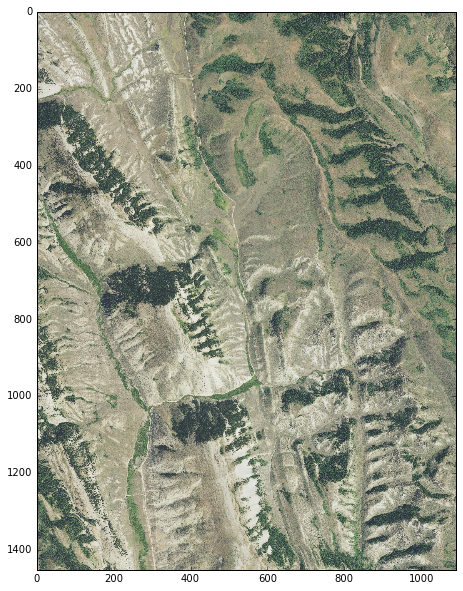

In [7]:
show_tif(source) 

and the reference image

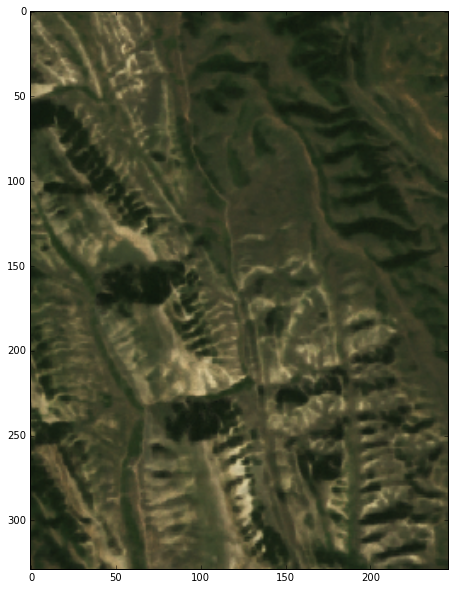

In [8]:
show_tif(reference8)

#### Matching in LCH (lightness-Chroma-Hue) color space

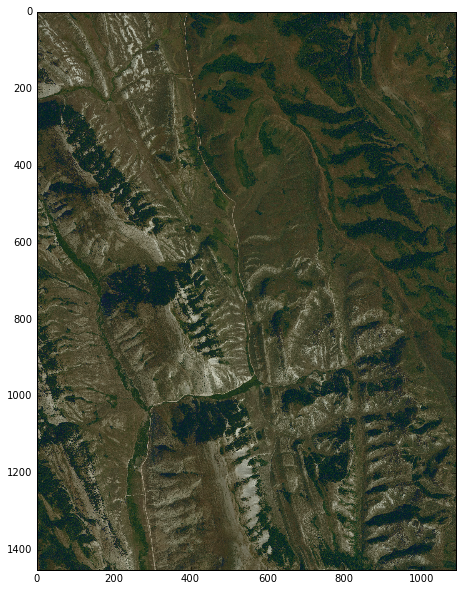

In [9]:
target_lch_path = "/tmp/target_match_lch.tif"

src_lch = cs_forward(src_arr, 'LCH')
ref_lch = cs_forward(ref_arr, 'LCH')

target_lch = src_lch.copy()

# Replace Lightness and Chroma with the version
# matched to the refernce histogram
target_lch[0] = hist_match(src_lch[0], ref_lch[0])
target_lch[1] = hist_match(src_lch[1], ref_lch[1])

# Note: We don't match on the third band, HUE
# - it's a radial measurement == discontinuous
# - By matching only Lightness and Chroma, we can avoid Blood River
# target_lch[2] = hist_match(src_lch[2], ref_lch[2])

target_match_lch = cs_backward(target_lch, 'LCH')


with rasterio.open(target_lch_path, 'w', **profile) as dst:
    dst.write(target_match_lch)
    
show_tif(target_lch_path)


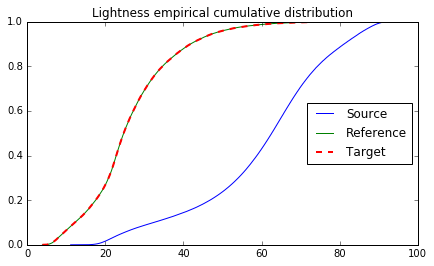

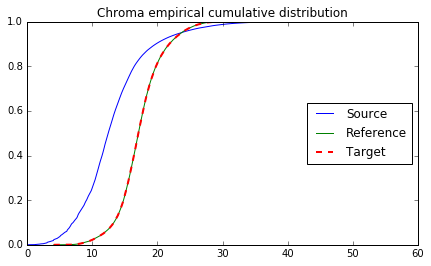

In [10]:
# plot the histograms
plot_cdfs(src_lch[0], ref_lch[0], target_lch[0], "Lightness")
plot_cdfs(src_lch[1], ref_lch[1], target_lch[1], "Chroma")

#### Matching in RGB (Red, Green, Blue) color space

In [ ]:
target_rgb_path = "/tmp/target_match_rgb.tif"

src_rgb = cs_forward(src_arr, 'RGB')
ref_rgb = cs_forward(ref_arr, 'RGB')

target_rgb = src_rgb.copy()

# Replace Red, Green and Blue with array
# matched to the refernce histogram
target_rgb[0] = hist_match(src_rgb[0], ref_rgb[0])
target_rgb[1] = hist_match(src_rgb[1], ref_rgb[1])
target_rgb[2] = hist_match(src_rgb[2], ref_rgb[2])

target_match_rgb = cs_backward(target_rgb, 'RGB')


with rasterio.open(target_rgb_path, 'w', **profile) as dst:
    dst.write(target_match_rgb)
    
show_tif(target_rgb_path)

In [ ]:
# plot the histograms
plot_cdfs(src_rgb[0], ref_rgb[0], target_rgb[0], "Red")
plot_cdfs(src_rgb[1], ref_rgb[1], target_rgb[1], "Green")
plot_cdfs(src_rgb[2], ref_rgb[2], target_rgb[2], "Blue")

## Discussion

Let's compare the LC-matched image with the RGB-match image:

In [ ]:
rcParams['figure.figsize'] = 15, 20
i1 = Image.open(source, 'r')
i2 = Image.open(reference8, 'r')
i3 = Image.open(target_lch_path, 'r') 
i4 = Image.open(target_rgb_path, 'r') 

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.imshow(i1)
ax1.set_title('Source (NAIP)')
ax2.imshow(i2)
ax2.set_title('Reference (Landsat)')
ax3.imshow(i3)
ax3.set_title('Matched to LC')
ax4.imshow(i4)
ax4.set_title('Matched to RGB')
plt.show()

plot_size('large')

#### Color space comparison

My first impressions are that "Match to LC" retains the best of both the source imagery and the reference. It has the same lightness and saturation of the reference image while retaining the hue of the source. 

The "Match to RGB" seems, to my eye, to badly distort the color, introducing a redish tint to the roads and other bright areas with exposed rock/sand.

Additional questions include:
* What other colorspaces/bands might be appropriate? What about full `LAB`, `HSL`, `YCbCr 
* Is ignoring hue-matching *really* a good thing or just in this case working with such disparate sources?
* 


#### Histogram matching algorithm

I haven't yet benchmarked it against alternatives  but the histogram matching algorithm presented above has performed reasonably quickly on small-medium imagery. It has no dependencies and just uses some simple numpy math.

Thus far, it has performed flawlessly, matching the source to reference histogram almost precisely in every case.

Comparison to the **KNN** approach? In [Amit's commenent here](https://github.com/mapbox/naip-processing/issues/10#issuecomment-44062066) he justifies the use of KNN based on 

> This implementation (referencing cdf value) has a major flaw. How do you compare CDF values? You can't use == because it's a floating point. Instead we use absolute distance, and choose the CDF that is closest.

 The problem with that logic is that there *is* an answer to the question "How do you compare CDF values?" - Linear interpolation. At the extreme ends of the cdf curve, snapping to the nearest value could indeed change pixel values dramatically. But not if they're interpolated. Additionally, these problems are more severe when working in RGB since it can throw the saturation off the charts for a particular hue.

The other potential approach is that of a **binned** lookup table but that's less precise and relies on scaling the data to an arbitrarily chosen bit-depth.

I can't yet think of any justification for using the KNN or binned approaches. The above works flawlessly across the entire dynamic range of all histograms I've thrown at it yet. Based on my understanding, this addresses all of the concerns that lead to the use of KNN.

